In [2]:
import os 
import sys
from pathlib import Path
from functools import partial
import xml.etree.ElementTree as ET #For reading and writing XML files
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import minimize
from rdkit import Chem
from rdkit.Chem import rdMolTransforms
from ase.units import Hartree, kcal, mol
kcalmol = kcal / mol

sys.path.append("/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/strain/utils")
from utils import parseQMoptE, curve_fit, QMoptE_list, CSD_hist, CSDTEU_list, sdf_ang_list, get_map_index

Plot func

In [18]:
def plotall(smarts,bincounts,func,min_E,rel_E,TEU_energies,degstatistics,xtaldeg,bestnofilter_deg,bestfilter_deg,cate,imgpath):
    # fig = plt.figure()
    # fig, axs = plt.subplots(1, 4, figsize=(60, 10), sharex=True, sharey=True)
    fig, axs = plt.subplots(1, 4, figsize=(60, 10), sharex=True)
    # 1. plot_TEU
    # ax1 = fig.add_subplot(111)
    for num in range(4):
        if num == 0:
            ax1 = axs[num]
            ax1.set_ylim(0,10000)
            x = list(range(-175,180,10))
            ax1.bar(x,bincounts, width=10, color="b",align="center",edgecolor="black",label="CSD histogram")
            # 2. plot_QMoptE
            angles = list(range(-180,181,15))
            probe_angs = list(range(-180,181,1))
            ax2 = ax1.twinx()
            lns1 = ax2.plot(probe_angs, np.array([ func(ang) for ang in probe_angs ]) - min_E, color = "black",label="QM fragment", linewidth=5)
            ax2.plot(angles, rel_E, color="red", marker="^", markersize=10,linestyle="")
            ax2.set_ylim(0,20)

            # 3. plot CSD-TEU
            lns2 = ax2.plot(probe_angs, TEU_energies, color="blue", label="CSD TEU",linewidth=5)
            lns = lns1+lns2
            labs = [l.get_label() for l in lns]

            # plt.close()
            plt.xlim(-185,185)
            x_major_locator = MultipleLocator(30) # The sep is set to 30
            ax = plt.gca() # the instance of 2 axes
            ax.xaxis.set_major_locator(x_major_locator)
            # plt.figure()
            font1 = {"family": "Helvetica", "weight": "normal", "size": 30}
            font2 = {"family": "Helvetica", "weight": "normal", "size": 23}
            ax1.set_title(smarts, font1)
            ax1.set_xlabel("Angle(degree)",font2)
            ax1.set_ylabel("CSD histogram count",font2)
            ax2.set_ylabel("QM relE(kcal/mol) or CSD TEU",font2)
            # ax2.plot(probe_angs, TEU_energies, color="black", marker="o", markersize=5,linestyle="")
            ax1.tick_params(labelsize=23)
            ax2.tick_params(labelsize=23)
            ax2.legend(lns, labs, loc="upper right",prop={"size":23})
            
        else:
            ax1 = axs[num]
            degs = degstatistics[num-1]
            ax1.hist(degs, bins=int(360/10), range=[-180,180],edgecolor="black")
            ax1.set_ylim(0,1000)
            ax2 = ax1.twinx()
            lns1 = ax2.plot(probe_angs, np.array([ func(ang) for ang in probe_angs ]) - min_E, color = "black",label="QM fragment", linewidth=5)
            ax2.plot(angles, rel_E, color="red", marker="^", markersize=10,linestyle="")
            ax2.set_ylim(0,20)
            lns2 = ax2.plot(probe_angs, TEU_energies, color="blue", label="CSD TEU",linewidth=5)
            ax1.tick_params(labelsize=23)
            ax2.tick_params(labelsize=23)
        plt.axvline(x=xtaldeg,color="red",linestyle="--")
        plt.axhline(y=1.7,color="blue", linestyle="--")
    axs[2].axvline(x=bestnofilter_deg,color="green",linestyle="--")
    axs[3].axvline(x=bestfilter_deg,color="green",linestyle="--")
    axs[1].set_ylim(0,500)
    axs[1].set_title(cate,font1)
    axs[2].set_title("nofilter",font1)
    axs[3].set_title("filter",font1)
    
    plt.savefig(imgpath / f"{cate}.png",facecolor = "white", transparent = False)
    plt.show()
    plt.close()



Main

  
                              unicon
    Universal molecule file converter and sampling (version: 1.4.0)
  
 Authored by:    K.Sommer                                       
 Many thanks to: Prof. M.Rarey and the whole AMD group          
 For more information visit <http://www.zbh.uni-hamburg.de/unicon>.
 Supported file formats:
   Input:
     MOL(*.mol) MOL2(*.mol2) PDB(*.pdb) SDF(*.sdf) SMILES(*.smi *.smiles) PDBx/mmCIF(*.cif *.mcif) InChI(*.inchi)
   Output:
     MOL2(*.mol2) SDF(*.sdf) SMILES(*.smi *.smiles) INCHI(*.inchi)
  
  Adding valid file to input: /pubhome/qcxia02/work/confgen/compounds/coreset/100/1nc3/conformer.1nc3-C.fixed.mol2
  Added 90 input files.
  
Starting workflow

  Entries: 90

  Using Entries 1 to 90

  Converting molecules.

  No coordinate generation, no sampling, just conversion
  
  Generated 90 molecules (conversion).

  Exiting program.

sel @/serialNumber=1 @/serialNumber=11 @/serialNumber=18 @/serialNumber=16
sel @/serialNumber=19 @/serialNumber=18 

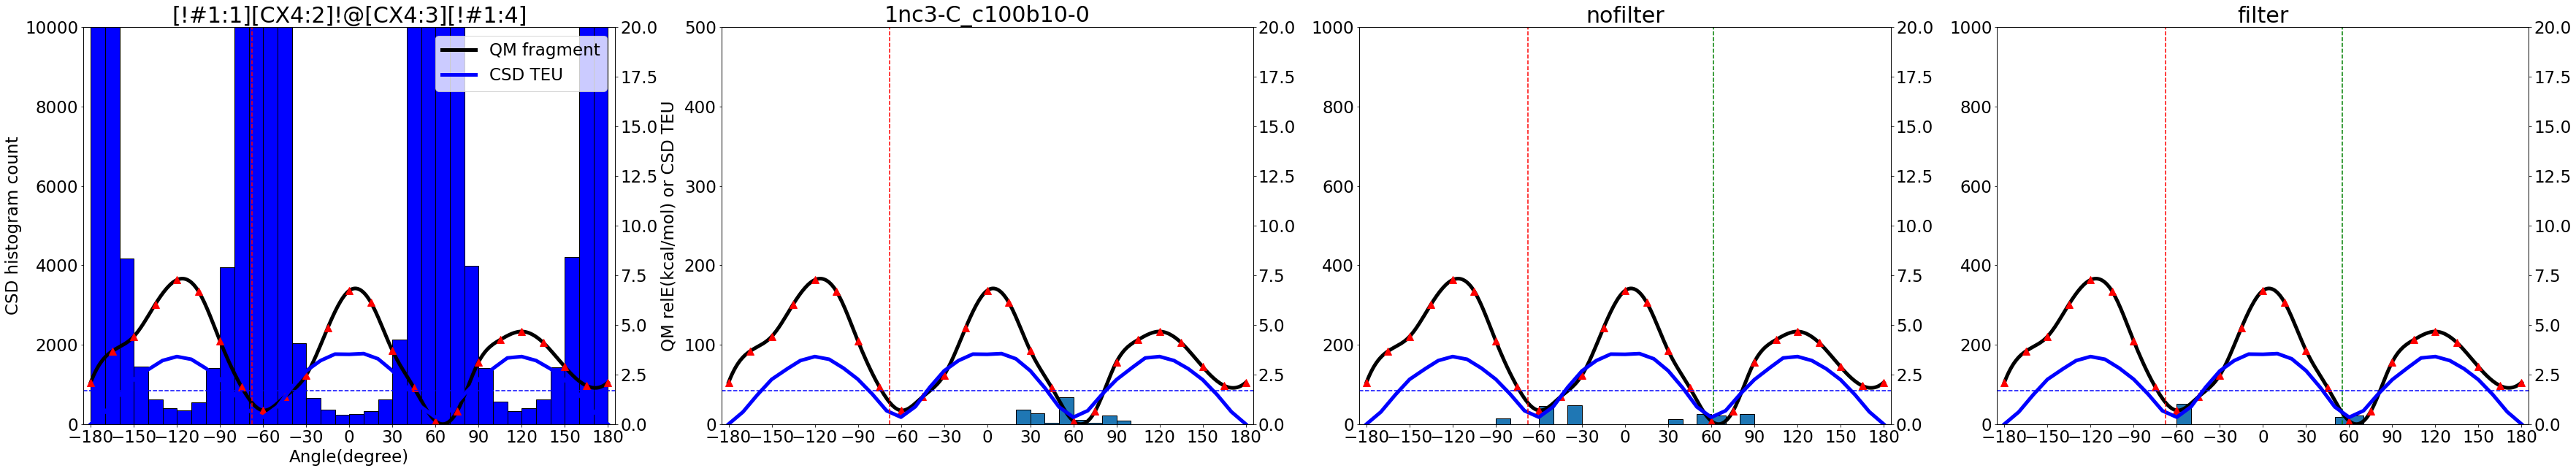

sel @/serialNumber=13 @/serialNumber=14 @/serialNumber=19 @/serialNumber=17
sel @/serialNumber=16 @/serialNumber=8 @/serialNumber=7 @/serialNumber=5
90 191 90
-11.485984970943385 169.99897012092106 169.9919700352824


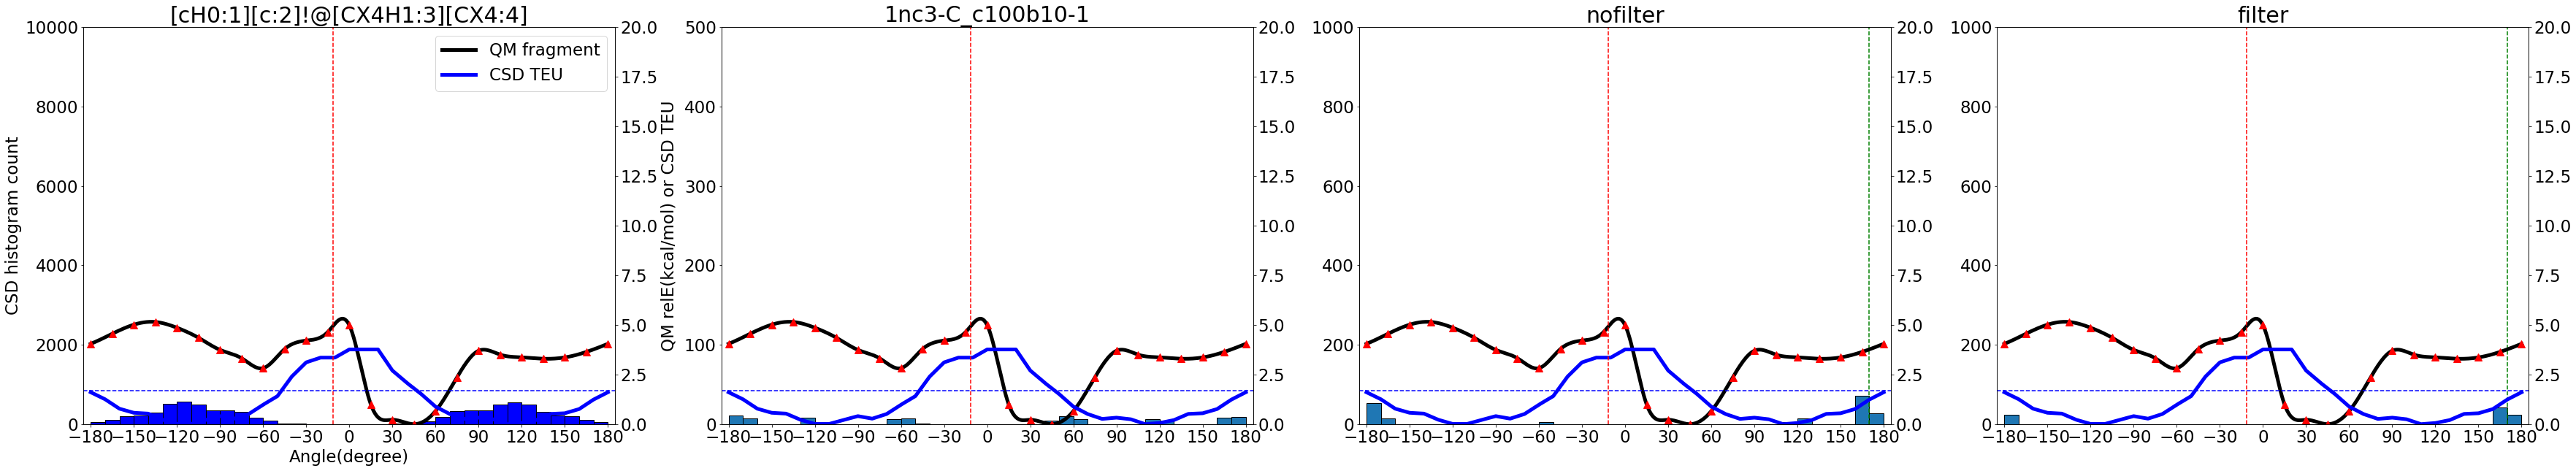

In [19]:
inpdbid = "1nc3"
TS = ['[!#1:1][CX4:2]!@[CX4:3][!#1:4]', '[cH0:1][c:2]!@[CX4H1:3][CX4:4]']
TQ = [[0, 10, 17, 15], [12, 13, 18, 16]]

# xmlfile = "/pubhome/qcxia02/Downloads/dataset/tor_lib/tor_lib_2020.xml"
# xmlfile = 'TorLibv21WCSDBins.xml'
xmlfile = "/pubhome/qcxia02/work/confgen/src/strain/TL_2.1_VERSION_6.xml"
xtalligpath = "/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/rdkit_Pfrag/pdbbind_mol2s"
rmsdsdfpath = "/pubhome/qcxia02/work/confgen/src/rmsd/result_rmsd"
qmgopath = "/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/rdkit_Pfrag/outputs/PDB/4QMGO"
imgpath = Path("/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/strain/strainimgs") / inpdbid

# maxconf = "1000"
# samptype = "T"
for samptype in ["C", "B", "R", "T"]:
    for maxconf in [100,250,1000]:
        cmpdpath = f"/pubhome/qcxia02/work/confgen/compounds/coreset/{maxconf}/{inpdbid}"
        os.system(f"unicon -i {cmpdpath}/conformer.{inpdbid}-{samptype}.fixed.mol2 -o /tmp/{inpdbid}-{samptype}.sdf")
        dockpath = f"/pubhome/qcxia02/work/confgen/dock/{inpdbid}/blastermaster"
        if not imgpath.exists():
            imgpath.mkdir()

        for i in range(len(TS)):
            xtalligsdf = f"{xtalligpath}/{inpdbid}.sdf"
            # sdffiles = [f"{dockpath}/dockingT_c100b10/test.sdf",f"{dockpath}/dockingT_c100b10d38/test.sdf"]
            # sdffiles = [f"{dockpath}/dockingT_c250b10/test.sdf",f"{dockpath}/dockingT_c250b10d38/test.sdf"]
            sdffiles = [f"/tmp/{inpdbid}-{samptype}.sdf", f"{dockpath}/docking{samptype}_c{maxconf}b10/test.sdf",f"{dockpath}/docking{samptype}_c{maxconf}b10d38/test.sdf"]
            optlogpath = Path(f"{qmgopath}/{inpdbid}_{i}")
            mapindex = get_map_index(xtalligsdf, sdffiles[0])
            smarts = TS[i]
            torquartet = TQ[i]
            modtorquartet = [ mapindex[i] for i in torquartet ]
            print(f"sel @/serialNumber={torquartet[0]+1} @/serialNumber={torquartet[1]+1} @/serialNumber={torquartet[2]+1} @/serialNumber={torquartet[3]+1}")
            print(f"sel @/serialNumber={modtorquartet[0]+1} @/serialNumber={modtorquartet[1]+1} @/serialNumber={modtorquartet[2]+1} @/serialNumber={modtorquartet[3]+1}")
            bincounts = CSD_hist(smarts, xmlfile) # result is the same as that in Torsion Analyzer
            rel_E, func, min_E = QMoptE_list(optlogpath=optlogpath) # QMoptE related infos
            TEU_energies = CSDTEU_list(smarts, xmlfile)
            sdffunc1 = partial(sdf_ang_list, torquartet=torquartet)
            sdffunc2 = partial(sdf_ang_list, torquartet=modtorquartet)
            degstatistics = list(map(sdffunc2, sdffiles))
            print(len(degstatistics[0]),len(degstatistics[1]),len(degstatistics[2]))
            xtaldeg = sdffunc1(xtalligsdf)[0]
            bestnofiltersdf = f"{rmsdsdfpath}/{inpdbid}.{samptype}_c{maxconf}b10.BestRMSDPose.sdf"
            bestfiltersdf = f"{rmsdsdfpath}/{inpdbid}.{samptype}_c{maxconf}b10d38.BestRMSDPose.sdf"
            bestnofilter_deg = sdffunc2(bestnofiltersdf)[0]
            bestfilter_deg = sdffunc2(bestfiltersdf)[0]
            print(xtaldeg, bestnofilter_deg, bestfilter_deg)
            plotall(
                smarts,bincounts,func,min_E,rel_E,TEU_energies,degstatistics,xtaldeg,bestnofilter_deg,bestfilter_deg,cate=f"{inpdbid}-{samptype}_c{maxconf}b10-{i}",imgpath=imgpath
        )

        os.system(f"rm /tmp/{inpdbid}-{samptype}.sdf")
        break
    break

  
                              unicon
    Universal molecule file converter and sampling (version: 1.4.0)
  
 Authored by:    K.Sommer                                       
 Many thanks to: Prof. M.Rarey and the whole AMD group          
 For more information visit <http://www.zbh.uni-hamburg.de/unicon>.
 Supported file formats:
   Input:
     MOL(*.mol) MOL2(*.mol2) PDB(*.pdb) SDF(*.sdf) SMILES(*.smi *.smiles) PDBx/mmCIF(*.cif *.mcif) InChI(*.inchi)
   Output:
     MOL2(*.mol2) SDF(*.sdf) SMILES(*.smi *.smiles) INCHI(*.inchi)
  
  Adding valid file to input: /pubhome/qcxia02/work/confgen/compounds/coreset/100/1nc3/conformer.1nc3-C.fixed.mol2
  Added 90 input files.
  
Starting workflow

  Entries: 90

  Using Entries 1 to 90

  Converting molecules.

  No coordinate generation, no sampling, just conversion
  
  Generated 90 molecules (conversion).

  Exiting program.

sel @/serialNumber=1 @/serialNumber=11 @/serialNumber=18 @/serialNumber=16
sel @/serialNumber=19 @/serialNumber=18 

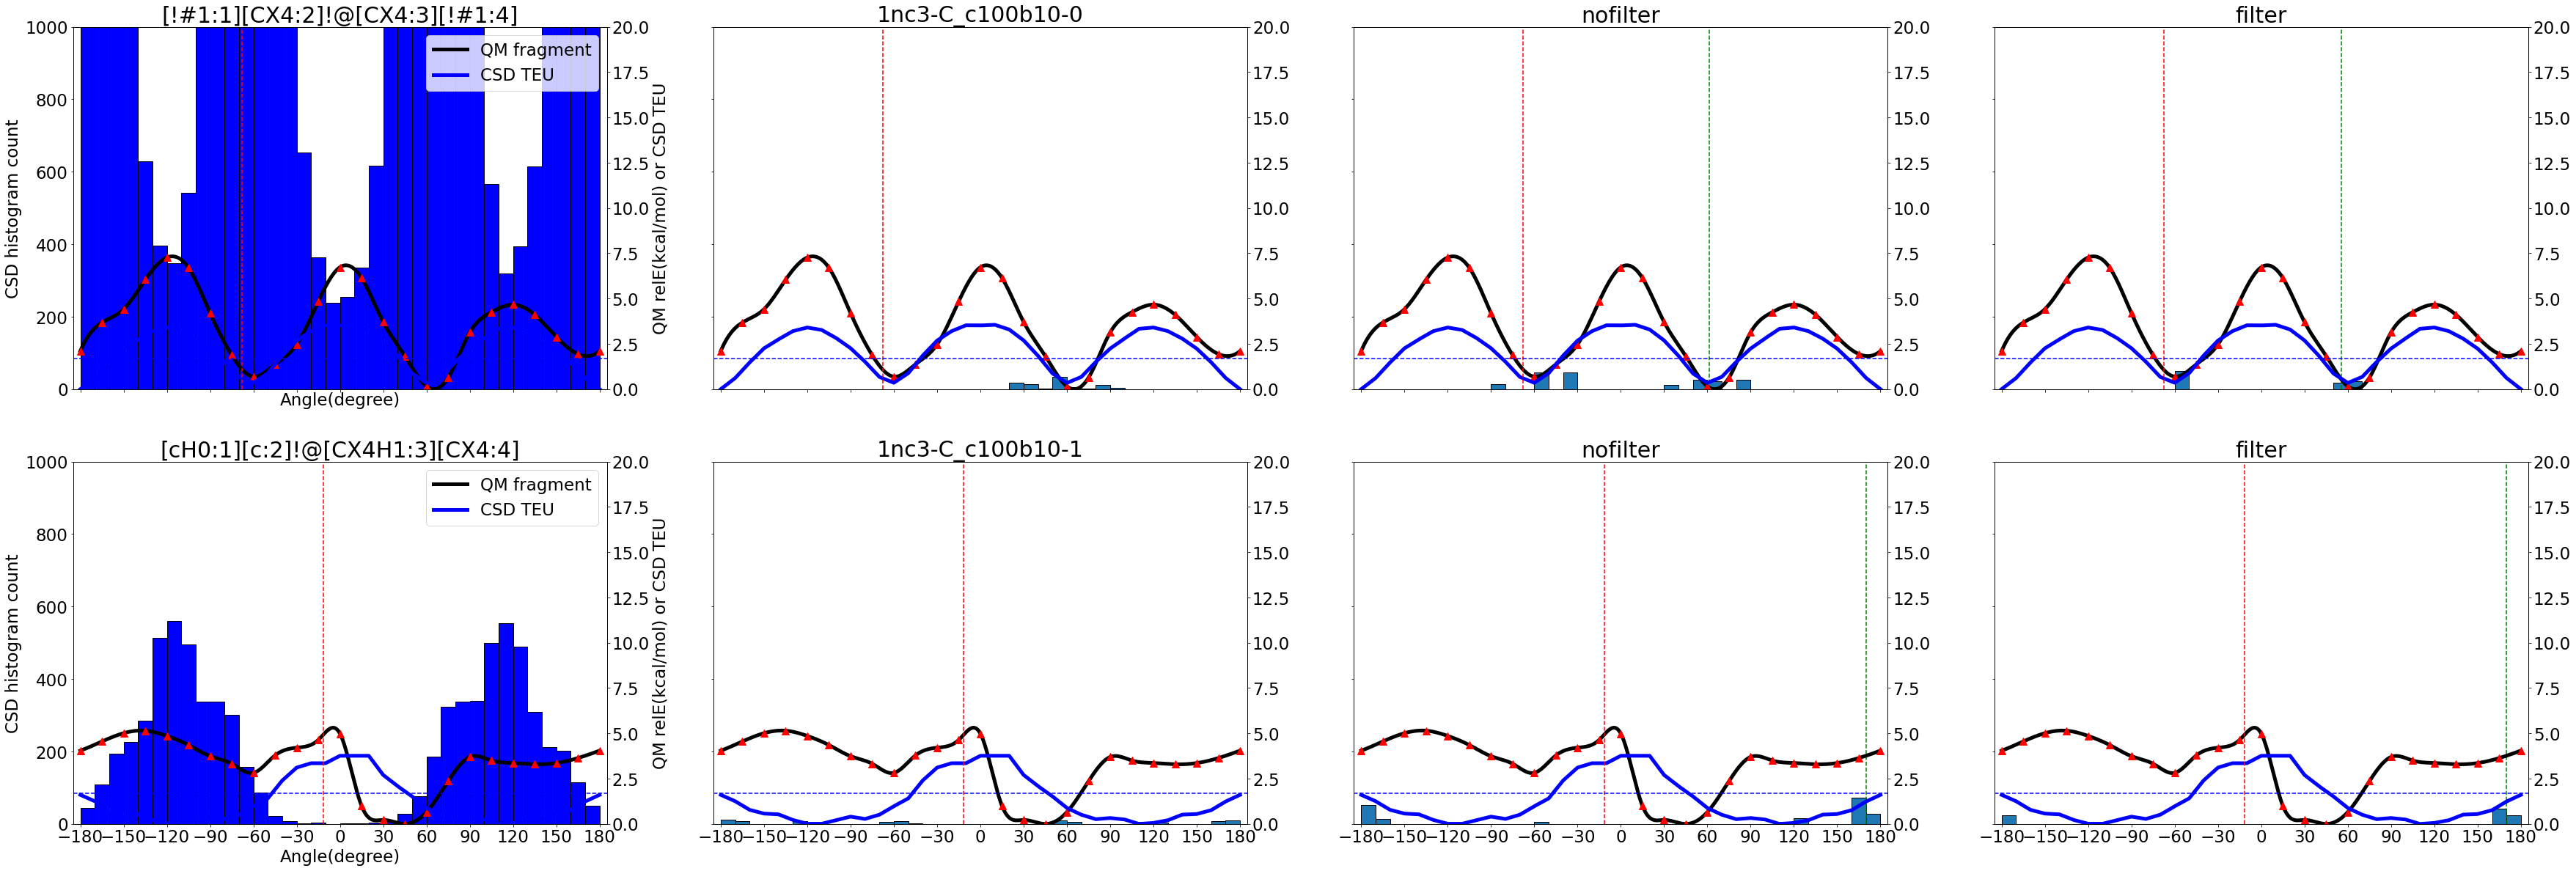

In [20]:
def plotallall(smarts,bincounts,func,min_E,rel_E,TEU_energies,degstatistics,xtaldeg,bestnofilter_deg,bestfilter_deg,cate,imgpath,rowidx,axs):
    # fig = plt.figure()
    # 1. plot_TEU
    # ax1 = fig.add_subplot(111)
    for num in range(4):
        if num == 0:
            ax1 = axs[rowidx][num]
            ax1.set_ylim(0,10000)
            x = list(range(-175,180,10))
            ax1.bar(x,bincounts, width=10, color="b",align="center",edgecolor="black",label="CSD histogram")
            # 2. plot_QMoptE
            angles = list(range(-180,181,15))
            probe_angs = list(range(-180,181,1))
            ax2 = ax1.twinx()
            lns1 = ax2.plot(probe_angs, np.array([ func(ang) for ang in probe_angs ]) - min_E, color = "black",label="QM fragment", linewidth=5)
            ax2.plot(angles, rel_E, color="red", marker="^", markersize=10,linestyle="")
            ax2.set_ylim(0,20)

            # 3. plot CSD-TEU
            lns2 = ax2.plot(probe_angs, TEU_energies, color="blue", label="CSD TEU",linewidth=5)
            lns = lns1+lns2
            labs = [l.get_label() for l in lns]

            # plt.close()
            plt.xlim(-185,185)
            x_major_locator = MultipleLocator(30) # The sep is set to 30
            ax = plt.gca() # the instance of 2 axes
            ax.xaxis.set_major_locator(x_major_locator)
            # plt.figure()
            font1 = {"family": "Helvetica", "weight": "normal", "size": 30}
            font2 = {"family": "Helvetica", "weight": "normal", "size": 23}
            ax1.set_title(smarts, font1)
            ax1.set_xlabel("Angle(degree)",font2)
            ax1.set_ylabel("CSD histogram count",font2)
            ax2.set_ylabel("QM relE(kcal/mol) or CSD TEU",font2)
            # ax2.plot(probe_angs, TEU_energies, color="black", marker="o", markersize=5,linestyle="")
            ax1.tick_params(labelsize=23)
            ax2.tick_params(labelsize=23)
            ax2.legend(lns, labs, loc="upper right",prop={"size":23})
            
        else:
            ax1 = axs[rowidx][num]
            degs = degstatistics[num-1]
            ax1.hist(degs, bins=int(360/10), range=[-180,180],edgecolor="black")
            ax1.set_ylim(0,1000)
            ax2 = ax1.twinx()
            lns1 = ax2.plot(probe_angs, np.array([ func(ang) for ang in probe_angs ]) - min_E, color = "black",label="QM fragment", linewidth=5)
            ax2.plot(angles, rel_E, color="red", marker="^", markersize=10,linestyle="")
            ax2.set_ylim(0,20)
            lns2 = ax2.plot(probe_angs, TEU_energies, color="blue", label="CSD TEU",linewidth=5)
            ax1.tick_params(labelsize=23)
            ax2.tick_params(labelsize=23)
        plt.axvline(x=xtaldeg,color="red",linestyle="--")
        plt.axhline(y=1.7,color="blue", linestyle="--")
    axs[rowidx][2].axvline(x=bestnofilter_deg,color="green",linestyle="--")
    axs[rowidx][3].axvline(x=bestfilter_deg,color="green",linestyle="--")
    axs[rowidx][1].set_title(cate,font1)
    axs[rowidx][2].set_title("nofilter",font1)
    axs[rowidx][3].set_title("filter",font1)

    return 


inpdbid = "1nc3"
TS = ['[!#1:1][CX4:2]!@[CX4:3][!#1:4]', '[cH0:1][c:2]!@[CX4H1:3][CX4:4]']
TQ = [[0, 10, 17, 15], [12, 13, 18, 16]]

# xmlfile = "/pubhome/qcxia02/Downloads/dataset/tor_lib/tor_lib_2020.xml"
# xmlfile = 'TorLibv21WCSDBins.xml'
xmlfile = "/pubhome/qcxia02/work/confgen/src/strain/TL_2.1_VERSION_6.xml"
xtalligpath = "/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/rdkit_Pfrag/pdbbind_mol2s"
rmsdsdfpath = "/pubhome/qcxia02/work/confgen/src/rmsd/result_rmsd"
qmgopath = "/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/rdkit_Pfrag/outputs/PDB/4QMGO"
imgpath = Path("/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/strain/strainimgs") / inpdbid

# maxconf = "1000"
# samptype = "T"

for samptype in ["C", "B", "R", "T"]:
    for maxconf in [100,250,1000]:
        rownum = len(TS)
        fig, axs = plt.subplots(rownum, 4, figsize=(60, 10*rownum), sharex=True, sharey=True)
        cmpdpath = f"/pubhome/qcxia02/work/confgen/compounds/coreset/{maxconf}/{inpdbid}"
        os.system(f"unicon -i {cmpdpath}/conformer.{inpdbid}-{samptype}.fixed.mol2 -o /tmp/{inpdbid}-{samptype}.sdf")
        dockpath = f"/pubhome/qcxia02/work/confgen/dock/{inpdbid}/blastermaster"
        if not imgpath.exists():
            imgpath.mkdir()

        for i in range(len(TS)):
            xtalligsdf = f"{xtalligpath}/{inpdbid}.sdf"
            # sdffiles = [f"{dockpath}/dockingT_c100b10/test.sdf",f"{dockpath}/dockingT_c100b10d38/test.sdf"]
            # sdffiles = [f"{dockpath}/dockingT_c250b10/test.sdf",f"{dockpath}/dockingT_c250b10d38/test.sdf"]
            sdffiles = [f"/tmp/{inpdbid}-{samptype}.sdf", f"{dockpath}/docking{samptype}_c{maxconf}b10/test.sdf",f"{dockpath}/docking{samptype}_c{maxconf}b10d38/test.sdf"]
            optlogpath = Path(f"{qmgopath}/{inpdbid}_{i}")
            mapindex = get_map_index(xtalligsdf, sdffiles[0])
            smarts = TS[i]
            torquartet = TQ[i]
            modtorquartet = [ mapindex[i] for i in torquartet ]
            print(f"sel @/serialNumber={torquartet[0]+1} @/serialNumber={torquartet[1]+1} @/serialNumber={torquartet[2]+1} @/serialNumber={torquartet[3]+1}")
            print(f"sel @/serialNumber={modtorquartet[0]+1} @/serialNumber={modtorquartet[1]+1} @/serialNumber={modtorquartet[2]+1} @/serialNumber={modtorquartet[3]+1}")
            bincounts = CSD_hist(smarts, xmlfile) # result is the same as that in Torsion Analyzer
            rel_E, func, min_E = QMoptE_list(optlogpath=optlogpath) # QMoptE related infos
            TEU_energies = CSDTEU_list(smarts, xmlfile)
            sdffunc1 = partial(sdf_ang_list, torquartet=torquartet)
            sdffunc2 = partial(sdf_ang_list, torquartet=modtorquartet)
            degstatistics = list(map(sdffunc2, sdffiles))
            print(len(degstatistics[0]),len(degstatistics[1]),len(degstatistics[2]))
            xtaldeg = sdffunc1(xtalligsdf)[0]
            bestnofiltersdf = f"{rmsdsdfpath}/{inpdbid}.{samptype}_c{maxconf}b10.BestRMSDPose.sdf"
            bestfiltersdf = f"{rmsdsdfpath}/{inpdbid}.{samptype}_c{maxconf}b10d38.BestRMSDPose.sdf"
            bestnofilter_deg = sdffunc2(bestnofiltersdf)[0]
            bestfilter_deg = sdffunc2(bestfiltersdf)[0]
            plotallall(
                smarts,bincounts,func,min_E,rel_E,TEU_energies,degstatistics,xtaldeg,bestnofilter_deg,bestfilter_deg,cate=f"{inpdbid}-{samptype}_c{maxconf}b10-{i}",imgpath=imgpath,rowidx=i,axs=axs
        )

        os.system(f"rm /tmp/{inpdbid}-{samptype}.sdf")
        break
    break

In [2]:
from rdkit import Chem

mol2file = "/pubhome/qcxia02/work/confgen/dock/2cet/blastermaster/dockingTLDRb10d38/tmp.mol2"
sdffile = "/pubhome/qcxia02/work/confgen/dock/2cet/blastermaster/dockingTLDRb10d38/tmp.sdf"

mol2mol = Chem.MolFromMol2File(mol2file, removeHs=False)
sdfmol = Chem.SDMolSupplier(sdffile, removeHs=False)[0]
mol2mol_ns = Chem.MolFromMol2File(mol2file, removeHs=False,sanitize=False)
sdfmol_ns = Chem.SDMolSupplier(sdffile, removeHs=False, sanitize=False)[0]
Chem.GetSymmSSSR(sdfmol_ns)

for mol in [mol2mol,sdfmol,mol2mol_ns,sdfmol_ns]:
    print(mol.GetAtomWithIdx(24).GetIsAromatic())
    print(mol.GetAtomWithIdx(15).GetIsAromatic())
    print(mol.GetSubstructMatches(Chem.MolFromSmarts("[CX3:1]=[CX3:2]!@[CH2:3][C:4]")))
    print(mol.GetSubstructMatches(Chem.MolFromSmarts("[a:1][c:2]!@[CX4H2:3][CX4:4]")))
    print()



True
True
()
((14, 15, 16, 17), (19, 18, 17, 16), (23, 18, 17, 16), (24, 15, 16, 17))

True
True
()
((14, 15, 16, 17), (19, 18, 17, 16), (23, 18, 17, 16), (24, 15, 16, 17))

False
False
((24, 15, 16, 17),)
((19, 18, 17, 16), (23, 18, 17, 16))

False
False


[14:31:10] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 129 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409060790/work/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



RuntimeError: Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 129 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.03.3
	BOOST: 1_74


In [6]:
from rdkit import Chem
sdmolfile = "/pubhome/qcxia02/work/confgen/src/rmsd/crystalligsdf/xtal-lig.uni.sdf"
mols = Chem.SDMolSupplier(sdmolfile, sanitize=False, removeHs = False)

# for mol in mols:
for i,mol in enumerate(mols):
    print(i)
    Chem.GetSymmSSSR(mol)
    mol.GetSubstructMatches(Chem.MolFromSmarts("[CX3:1]=[CX3:2]!@[CH2:3][C:4]"))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
